In [23]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the Automobile MPG dataset from OpenML
#mpg = fetch_openml(name='autompg',version=3)
mpg = fetch_openml(data_id=42372)
# Convert to DataFrame
X = pd.DataFrame(mpg.data, columns=mpg.feature_names)
y = pd.DataFrame(mpg.target)



In [24]:
from PSO_UQ1 import PSO_UQ
from GA_UQ1 import GA_UQ


In [25]:
# Concatenate features and target into a single DataFrame
df = pd.concat([X, y], axis=1)

# Remove rows with NaN values
df = df.dropna()
df= df.apply(pd.to_numeric, errors='coerce')
df = df.reset_index(drop=True)
# Split the dataset into features and target
X = df.drop('Mpg', axis=1)
y = df['Mpg']

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X)
X=X_train_scaled
y_train=y
results=[]
PSO_fitnesses=[]
GA_instances=[]


In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import time as t
import numpy as np
from scipy.stats import t as t_dist

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    mean_val = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin = sem * t_dist.ppf((1 + confidence) / 2.0, n - 1)
    return mean_val, mean_val - margin, mean_val + margin

def trainAndreport(name, model, runs=30):
    all_results = []

    for run in range(runs):
        kfold = KFold(n_splits=10, shuffle=True, random_state=42 + run)
        predictions = []
        actual_values = []

        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            predictions.extend(y_pred)
            actual_values.extend(y_test)

        predictions = np.array(predictions)
        actual_values = np.array(actual_values)

        test_r2 = r2_score(actual_values, predictions)
        test_rmse = root_mean_squared_error(actual_values, predictions)

        # GA
        start_time = t.time()
        solution, solution_fitness, ga_instance = GA_UQ(predictions, actual_values)
        ga_duration = t.time() - start_time
        a_ga, b_ga = solution
        lower_ga = predictions - b_ga
        upper_ga = predictions + a_ga
        picp_ga = np.mean((actual_values >= lower_ga) & (actual_values <= upper_ga))
        mpiw_ga = np.mean(upper_ga - lower_ga)

        # PSO
        start_time = t.time()
        pos, cost, optimizer, fitness = PSO_UQ(predictions, actual_values, iters=1000)
        pso_duration = t.time() - start_time
        a_pso, b_pso = pos
        lower_pso = predictions - b_pso
        upper_pso = predictions + a_pso
        picp_pso = np.mean((actual_values >= lower_pso) & (actual_values <= upper_pso))
        mpiw_pso = np.mean(upper_pso - lower_pso)

        # Optional: track fitness or instance details if needed
        PSO_fitnesses.append(fitness)
        GA_instances.append(ga_instance)

        result = {
        "Model": name,
        "R2": test_r2,
        "RMSE": test_rmse,
        "a_PSO": a_pso,
        "b_PSO": b_pso,
        "Fitness_PSO": -cost,
        "PICP_PSO": picp_pso,
        "MPIW_PSO": mpiw_pso,
        "time_PSO": pso_duration,
        "a_GA": a_ga,
        "b_GA": b_ga,
        "Fitness_GA": solution_fitness,
        "PICP_GA": picp_ga,
        "MPIW_GA": mpiw_ga,
        "time_GA": ga_duration
        }

        all_results.append(result)


    results.extend(all_results)  # Add all to global result list if needed


In [28]:
from sklearn.linear_model import LinearRegression
trainAndreport("Linear Regression",LinearRegression())

c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:744: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause

In [29]:
from sklearn.svm import SVR
trainAndreport("SVR",SVR())

c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:744: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause

In [30]:
from sklearn.ensemble import RandomForestRegressor
trainAndreport("Random Forest", RandomForestRegressor(random_state=42))

c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:744: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
trainAndreport("GradientBoostingRegressor", GradientBoostingRegressor(random_state=42))

c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:744: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
c:\Users\naima\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygad\pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause

In [32]:
import pandas as pd

# Convert list of result dictionaries into a DataFrame
results_df = pd.DataFrame(results)

# Round for readability (optional)
results_df = results_df.round(3)


In [33]:
# 📊 1. Mean Table per Model
mean_df = results_df.groupby("Model").mean(numeric_only=True).reset_index()
print("\n📌 Mean Table Per Model:")
print(mean_df.to_string(index=False))


📌 Mean Table Per Model:
                    Model       R2     RMSE    a_PSO    b_PSO  Fitness_PSO  PICP_PSO  MPIW_PSO  time_PSO     a_GA     b_GA  Fitness_GA  PICP_GA   MPIW_GA  time_GA
GradientBoostingRegressor 0.870833 2.801000 4.735933 4.486967     0.010033  0.912333  9.222933  1.147667 4.734467 4.483733    0.010033 0.912000  9.218200 0.974400
        Linear Regression 0.801633 3.471533 7.393767 6.734100     0.007000  0.952900 14.127833  1.489233 7.392367 6.733900    0.007000 0.953067 14.126333 1.225700
            Random Forest 0.877733 2.725133 4.350333 4.211800     0.010733  0.908967  8.562167  1.161700 4.355267 4.216033    0.010733 0.909267  8.571267 0.996633
                      SVR 0.844967 3.068267 4.940767 5.132933     0.009900  0.935233 10.073567  1.283600 4.941167 5.133867    0.009900 0.935400 10.075000 1.088233


In [51]:
print(mean_df.drop(columns=['time_PSO','time_GA','Fitness_PSO','Fitness_PSO']))

                       Model        R2      RMSE     a_PSO     b_PSO  \
0  GradientBoostingRegressor  0.870833  2.801000  4.735933  4.486967   
1          Linear Regression  0.801633  3.471533  7.393767  6.734100   
2              Random Forest  0.877733  2.725133  4.350333  4.211800   
3                        SVR  0.844967  3.068267  4.940767  5.132933   

   PICP_PSO   MPIW_PSO      a_GA      b_GA  Fitness_GA   PICP_GA    MPIW_GA  
0  0.912333   9.222933  4.734467  4.483733    0.010033  0.912000   9.218200  
1  0.952900  14.127833  7.392367  6.733900    0.007000  0.953067  14.126333  
2  0.908967   8.562167  4.355267  4.216033    0.010733  0.909267   8.571267  
3  0.935233  10.073567  4.941167  5.133867    0.009900  0.935400  10.075000  


In [66]:
import numpy as np
from scipy.stats import t as t_dist

# Your original mean table
mean_df = results_df.groupby("Model").mean(numeric_only=True).reset_index()

# CI function
def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    mean_val = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin = sem * t_dist.ppf((1 + confidence) / 2.0, n - 1)
    return 2 * margin  # total CI width

# Compute CI width for each model
ci_data = []
for model, group in results_df.groupby("Model"):
    row = {"Model": model}
    for col in ["MPIW_PSO", "MPIW_GA"]:
        if col in group.columns:
            ci_width = mean_confidence_interval(group[col].dropna())
            row[f"{col}_CI95"] = round(ci_width, 4)
    ci_data.append(row)

# Create CI DataFrame
ci_df = pd.DataFrame(ci_data)

# Merge into mean_df
mean_df = mean_df.merge(ci_df, on="Model", how="left")

# Print

newdf=mean_df.drop(columns=['time_PSO','time_GA','Fitness_PSO'])
print(newdf[['Model', 'R2', 'RMSE', 'a_PSO', 'b_PSO', 'PICP_PSO', 'MPIW_PSO','MPIW_PSO_CI95', 'a_GA',
       'b_GA', 'PICP_GA', 'MPIW_GA', 
       'MPIW_GA_CI95']])


                       Model        R2      RMSE     a_PSO     b_PSO  \
0  GradientBoostingRegressor  0.870833  2.801000  4.735933  4.486967   
1          Linear Regression  0.801633  3.471533  7.393767  6.734100   
2              Random Forest  0.877733  2.725133  4.350333  4.211800   
3                        SVR  0.844967  3.068267  4.940767  5.132933   

   PICP_PSO   MPIW_PSO  MPIW_PSO_CI95      a_GA      b_GA   PICP_GA  \
0  0.912333   9.222933         0.2617  4.734467  4.483733  0.912000   
1  0.952900  14.127833         0.0514  7.392367  6.733900  0.953067   
2  0.908967   8.562167         0.2780  4.355267  4.216033  0.909267   
3  0.935233  10.073567         0.0789  4.941167  5.133867  0.935400   

     MPIW_GA  MPIW_GA_CI95  
0   9.218200        0.2662  
1  14.126333        0.0514  
2   8.571267        0.2719  
3  10.075000        0.0766  


In [57]:
import numpy as np
import pandas as pd
from scipy.stats import t as t_dist

def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    mean_val = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin = sem * t_dist.ppf((1 + confidence) / 2.0, n - 1)
    return margin  # Only return margin, since we only care about CI width

# Metrics to include in summary
target_metrics = ["MPIW_PSO", "MPIW_GA", "time_PSO", "time_GA", "Fitness_PSO", "Fitness_GA"]

# For Auto dataset only
summary_data = []
grouped = results_df.groupby("Model")

for model, group in grouped:
    for metric in target_metrics:
        if metric in group.columns:
            values = group[metric].dropna()
            margin = mean_confidence_interval(values)
            summary_data.append({
                "Dataset": "Auto",
                "Model": model,
                "Metric": metric,
                "95% CI Width": round(2 * margin, 4)  # Total CI width (upper - lower)
            })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Display
print("\n📊 95% Confidence Interval Widths Only (Auto dataset):")
print(summary_df.to_string(index=False))




📊 95% Confidence Interval Widths Only (Auto dataset):
Dataset                     Model      Metric  95% CI Width
   Auto GradientBoostingRegressor    MPIW_PSO        0.2617
   Auto GradientBoostingRegressor     MPIW_GA        0.2662
   Auto GradientBoostingRegressor    time_PSO        0.0406
   Auto GradientBoostingRegressor     time_GA        0.0561
   Auto GradientBoostingRegressor Fitness_PSO        0.0001
   Auto GradientBoostingRegressor  Fitness_GA        0.0001
   Auto         Linear Regression    MPIW_PSO        0.0514
   Auto         Linear Regression     MPIW_GA        0.0514
   Auto         Linear Regression    time_PSO        0.3698
   Auto         Linear Regression     time_GA        0.2696
   Auto         Linear Regression Fitness_PSO        0.0000
   Auto         Linear Regression  Fitness_GA        0.0000
   Auto             Random Forest    MPIW_PSO        0.2780
   Auto             Random Forest     MPIW_GA        0.2719
   Auto             Random Forest    time_PSO

In [48]:
summary_df.to_excel("summary_metrics_CI_auto.xlsx", index=False, engine='openpyxl')  # index=False prevents writing row numbers


In [62]:
import numpy as np
import pandas as pd
from scipy.stats import t as t_dist

def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    mean_val = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    margin = sem * t_dist.ppf((1 + confidence) / 2.0, n - 1)
    return mean_val, 2 * margin  # Return mean and total width of CI

# Create a compact summary table for time only (across all models)
summary_data = []
for opt in ['time_PSO', 'time_GA']:
    if opt in results_df.columns:
        values = results_df[opt].dropna()
        mean, ci_width = mean_confidence_interval(values)
        summary_data.append({
            "Dataset":"Auto",
            "Optimizer": opt.replace("time_", ""),
            "Mean Time (s)": round(mean, 4),
            "95% CI Width": round(ci_width, 4)
        })

summary_df = pd.DataFrame(summary_data)

# Display result
print("\n📊 Average Optimization Time and 95% CI Width (All Models Combined):")
print(summary_df.to_string(index=False))



📊 Average Optimization Time and 95% CI Width (All Models Combined):
Dataset Optimizer  Mean Time (s)  95% CI Width
   Auto       PSO         1.2706        0.1055
   Auto        GA         1.0712        0.0796


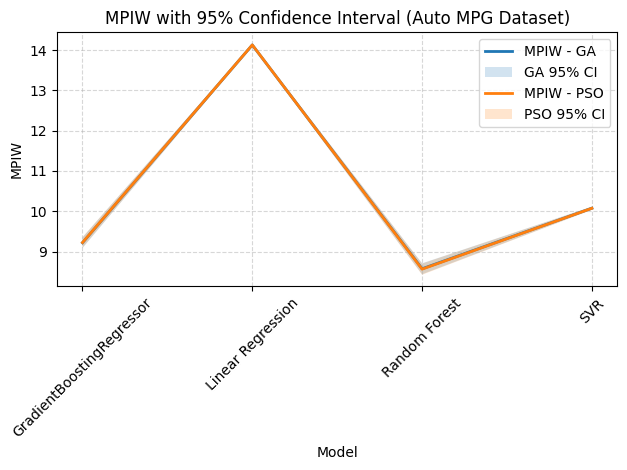

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Filter for MPIW ---
mpiws = summary_df[summary_df['Metric'].str.contains('MPIW')].copy()
mpiws['Optimizer'] = mpiws['Metric'].apply(lambda x: 'GA' if 'GA' in x else 'PSO')

# Set order of models (you can adjust this manually)
model_order = mpiws['Model'].unique()

# Pivot the data for plotting
for opt in ['GA', 'PSO']:
    df_opt = mpiws[mpiws['Optimizer'] == opt]
    df_opt = df_opt.set_index('Model').loc[model_order]  # order models

    plt.plot(df_opt.index, df_opt['Mean'], label=f'MPIW - {opt}', linewidth=2)
    plt.fill_between(
        df_opt.index,
        df_opt['95% CI Lower'],
        df_opt['95% CI Upper'],
        alpha=0.2,
        label=f'{opt} 95% CI'
    )

plt.title('MPIW with 95% Confidence Interval (Auto MPG Dataset)')
plt.ylabel('MPIW')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



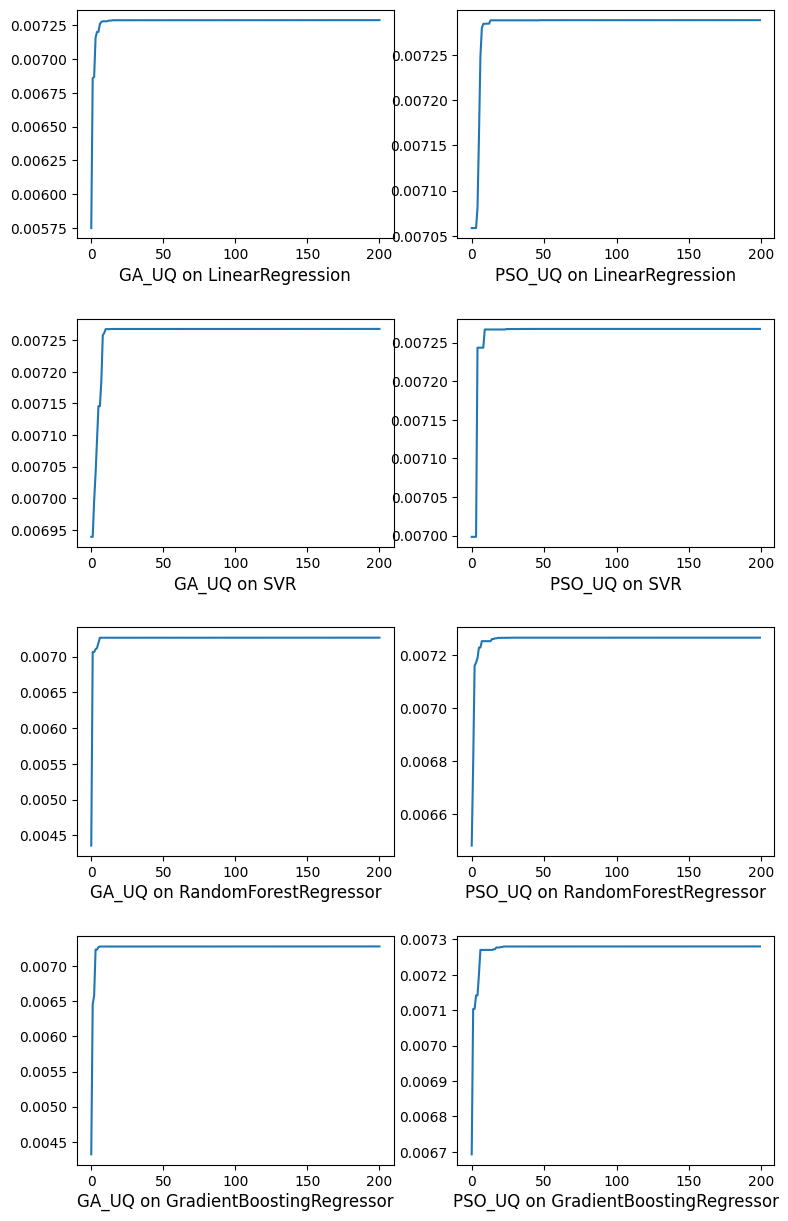

In [44]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(4,2,figsize=(9,15))
names=["LinearRegression","SVR","RandomForestRegressor","GradientBoostingRegressor"]
for i in range(4):
    y=np.maximum.accumulate(GA_instances[i].solutions_fitness)[::16]
    x=range(len(y))
    ax[i,0].plot(x,y)
    x=range(len(PSO_fitnesses[i]))
    y=PSO_fitnesses[i]
    ax[i,1].plot(x,y)
    ax[i,0].set_title("GA_UQ on "+names[i],y=-.22)
    ax[i,1].set_title("PSO_UQ on "+names[i],y=-.22)
plt.subplots_adjust(hspace=0.35)

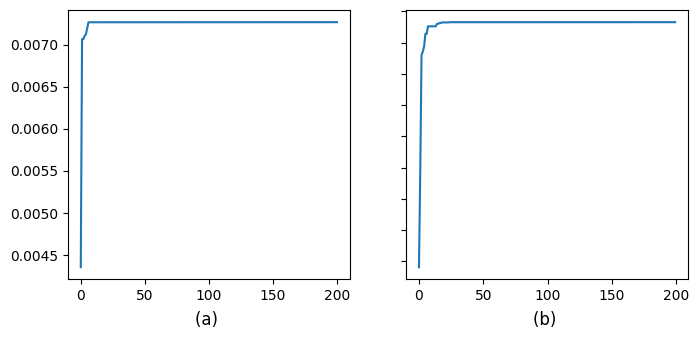

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(8,3.5))
names=["LinearRegression","SVR","RandomForestRegressor","GradientBoostingRegressor"]
i=0
y=np.maximum.accumulate(GA_instances[i].solutions_fitness)[::16]
x=range(len(y))
ax[0].plot(x,y)
x=range(len(PSO_fitnesses[i]))
y=PSO_fitnesses[i]
ax[1].plot(x,y)
ax[0].set_title("(a) ",y=-.2)
ax[1].set_title("(b) ",y=-.2)
plt.savefig('linear_regression.pdf', dpi=300)  # Set DPI to 300 for higher quality
